# **Fera Formidável 4.2**

* Caio M. C. Ruas - RM: 24010
* Thalles José de S. Cansi - RM: 24006

## Introdução

Nessa fera, o objetivo era implementar uma estratégia de parada antecipada em uma rede neural feita em python puro ou no processo desenvolvido em disciplina envolvendo o `PyTorch`.

Em redes neurais, treinar por um número excessivo de épocas pode levar ao overfitting. Isso significa que a rede começa a memorizar os dados de treinamento, incluindo ruídos e detalhes específicos, em vez de aprender os padrões gerais. Como resultado, o desempenho em dados de treinamento melhora continuamente, mas a capacidade de generalizar para dados novos e não vistos diminui significativamente.

Para evitar o overfitting, uma técnica eficaz é a parada antecipada (early stopping). Durante o treinamento, além do conjunto de treinamento, utilizamos um conjunto de validação, que a rede nunca viu antes. Monitoramos o desempenho da rede nesse conjunto de validação a cada época. Inicialmente, o desempenho tanto no treinamento quanto na validação tende a melhorar. No entanto, se o desempenho no conjunto de validação para de melhorar ou começa a piorar enquanto o desempenho no treinamento continua a aumentar, isso indica que o overfitting está começando a ocorrer. Nesse ponto, aplicamos a parada antecipada, interrompendo o treinamento para "capturar" o modelo em um estado onde ele ainda generaliza bem, antes de se especializar demais nos dados de treinamento.

Sendo assim, será aplicado o conceito de parada antecipada em uma rede neural simples, modificando o código da rede neural em python puro feito na disciplina.

**Observação:** A rede neural feita durante a disciplina foi utilizada como base para a implementação das novas funções de ativação. Neste notebook, está presente apenas a versão adaptada ao objetivo da atividade, com as funções de ativação modificadas. A versão original da rede neural pode ser encontrada em `colocar link git`

### Rede Neural Modificada

In [1]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __gt__(self, outro_valor):
        """Realiza a operação: self > outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data > outro_valor.data else 0.0
        return Valor(data)
    
    def __ge__(self, outro_valor):
        """Realiza a operação: self >= outro_valor"""
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
        data = 1.0 if self.data >= outro_valor.data else 0.0
        return Valor(data)

    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [2]:
import random

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [3]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [4]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

### Modificando o código de treinamento

Para implementar a parada antecipada, foi necessário modificar a função responsável pelo treinamento da rede neural em épocas. A ideia é monitorar o desempenho da rede em um conjunto de validação e interromper o treinamento quando o desempenho começar a piorar.

In [5]:
def otimizacao_em_epocas(mlp, x_train, y_true_train, x_val, y_true_val, num_epocas, taxa_de_aprendizado):
    """
    Realiza a otimização do MLP em épocas, utilizando o algoritmo de backpropagation.
    """

    train_losses = []
    val_losses = []

    for epoca in range(num_epocas):

        #   Parada antecipada
        if len(val_losses) > 2 and val_losses[-1] > val_losses[-2]:
            print("Validação: Aumento do erro, interrompendo treinamento.")
            return train_losses, val_losses

        #   Forward pass (treino)
        y_pred_train = []
        for exemplo in x_train:
            previsao = mlp(exemplo)
            y_pred_train.append(previsao)  #   Armazena apenas o valor escalar

        # y_pred_train = [pred[0] for pred in y_pred_train]

        #   Loss (treino)
        erros_train = []
        for yt, yp in zip(y_true_train, y_pred_train):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_train.append(erro_quadratico)
        loss_train = sum(erros_train)

        #   Forward pass (validação)
        y_pred_val = []
        for exemplo in x_val:
            previsao = mlp(exemplo)
            y_pred_val.append(previsao)  #   Armazena apenas o valor escalar

        # y_pred_val = [pred[0] for pred in y_pred_val]

        #   Loss (validação)
        erros_val = []
        for yt, yp in zip(y_true_val, y_pred_val):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_val.append(erro_quadratico)
        loss_val = sum(erros_val)

        #   Zero grad
        for p in mlp.parametros():
            p.grad = 0

        #   Backpropagation
        loss_train.propagar_tudo()  #   Propaga o gradiente a partir do loss de treino

        #   Atualiza parâmetros
        for p in mlp.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        #   Armazena os valores de loss
        train_losses.append(loss_train.data)
        val_losses.append(loss_val.data)

        #   Mostra resultado (opcional)
        print(f"Época {epoca}, Loss Treino: {loss_train.data:.4f}, Loss Validação: {loss_val.data:.4f}")
    
    return train_losses, val_losses

### Teste em dados artificiais

Época 0, Loss Treino: 0.6264, Loss Validação: 0.0034
Época 1, Loss Treino: 0.6246, Loss Validação: 0.0032
Época 2, Loss Treino: 0.6228, Loss Validação: 0.0030
Época 3, Loss Treino: 0.6210, Loss Validação: 0.0028
Época 4, Loss Treino: 0.6193, Loss Validação: 0.0026
Época 5, Loss Treino: 0.6176, Loss Validação: 0.0024
Época 6, Loss Treino: 0.6160, Loss Validação: 0.0022
Época 7, Loss Treino: 0.6143, Loss Validação: 0.0021
Época 8, Loss Treino: 0.6128, Loss Validação: 0.0019
Época 9, Loss Treino: 0.6112, Loss Validação: 0.0018
Época 10, Loss Treino: 0.6097, Loss Validação: 0.0016
Época 11, Loss Treino: 0.6083, Loss Validação: 0.0015
Época 12, Loss Treino: 0.6068, Loss Validação: 0.0014
Época 13, Loss Treino: 0.6054, Loss Validação: 0.0013
Época 14, Loss Treino: 0.6041, Loss Validação: 0.0012
Época 15, Loss Treino: 0.6027, Loss Validação: 0.0010
Época 16, Loss Treino: 0.6014, Loss Validação: 0.0009
Época 17, Loss Treino: 0.6002, Loss Validação: 0.0009
Época 18, Loss Treino: 0.5989, Loss Va

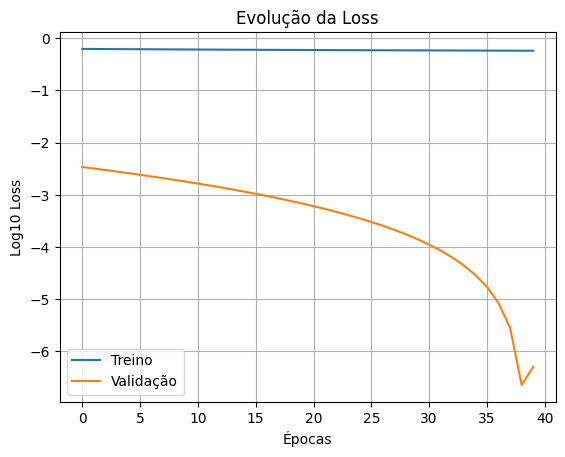

In [6]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
y_true = [1, 0, 0.2, 0.5]

porcentagem_treino = 0.8
num_exemplos = len(x)
num_treino = int(num_exemplos * porcentagem_treino)

x_train = x[:num_treino]
y_true_train = y_true[:num_treino]
x_val = x[num_treino:]
y_true_val = y_true[num_treino:]

NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
minha_mlp_teste = MLP(NUM_DADOS_DE_ENTRADA, CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA])

NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.02 

train_losses, val_losses = otimizacao_em_epocas(
    minha_mlp_teste, x_train, y_true_train, x_val, y_true_val, NUM_EPOCAS, TAXA_DE_APRENDIZADO
)

train_losses_log = [math.log10(loss) for loss in train_losses]
val_losses_log = [math.log10(loss) for loss in val_losses]

import matplotlib.pyplot as plt

plt.plot(train_losses_log, label="Treino")
plt.plot(val_losses_log, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Log10 Loss")
plt.title("Evolução da Loss")
plt.legend()
plt.grid()
plt.show()

### Implementação em conjunto de dados

Terminar

In [7]:
import seaborn as sns

iris = sns.load_dataset("iris")
print(iris.head())


C:\Users\caio24010\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [8]:
iris = iris.drop(columns=["species"])

x = []
y = []

for i in range(len(iris)):
    x.append([iris.iloc[i]["sepal_length"], iris.iloc[i]["sepal_width"], iris.iloc[i]["petal_length"]])
    y.append(iris.iloc[i]["petal_width"])

porcentagem_treino = 0.8
num_exemplos = len(x)
num_treino = int(num_exemplos * porcentagem_treino)
x_train = x[:num_treino]
y_true_train = y[:num_treino]
x_val = x[num_treino:]
y_true_val = y[num_treino:]
NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [3, 2]
minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA])

NUM_EPOCAS = 100
TAXA_DE_APRENDIZADO = 0.5
train_losses, val_losses = otimizacao_em_epocas(
    minha_mlp, x_train, y_true_train, x_val, y_true_val, NUM_EPOCAS, TAXA_DE_APRENDIZADO
)

train_losses_log = [math.log10(loss) for loss in train_losses]
val_losses_log = [math.log10(loss) for loss in val_losses]

Época 0, Loss Treino: 111.8300, Loss Validação: 86.7443
Época 1, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 2, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 3, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 4, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 5, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 6, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 7, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 8, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 9, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 10, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 11, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 12, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 13, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 14, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 15, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 16, Loss Treino: 59.4700, Loss Validação: 33.0600
Época 17, Loss Treino: 59.4700, Loss Validação: 33.0600
É

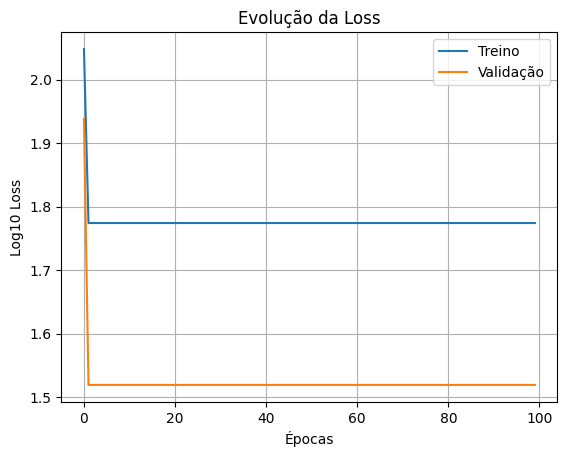

In [9]:
plt.plot(train_losses_log, label="Treino")
plt.plot(val_losses_log, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Log10 Loss")
plt.title("Evolução da Loss")
plt.legend()
plt.grid()
plt.show()

## Conclusão



## Referências

$^{[1]}$ BKASHYAP, P. Early Stopping in Deep Learning: A Simple Guide to Prevent Overfitting. Disponível em: <https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e>. 

$^{[2]}$ 

$^{[3]}$ 